# Find all possible output states (fidelity and Bell-diagonal elements) from a purification protocol

In [1]:
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
from scipy.io import savemat

## Functions

In [2]:
def base(M, n):
    # calculate the image of the base under a matrix M
    
    # make a set of all combinations of the first column and the last n columns (these correspond to X_1, Z_1,...,Z_n)
    s = []
    for i in range(n+1, 2*n):
        s.append(M[0:2*n, i])
    powerset = it.chain.from_iterable(it.combinations(s, r) for r in range(1, len(s)+1))
    
    res = [vector(GF(2),2*n)]
        
    for i in powerset:
        v = vector(sum(i))     # calculate the sum of the elements of each combination (e.g IZZ = IZI + IIZ)
        res.append(v)
        
    return res

In [3]:
def pillars(M, n):
    # calculate the image of the pillars under a matrix M
    
    X1 = vector(M[0:2*n, 0])
    Z1 = vector(M[0:2*n, n])
    Y1 = X1 + Z1
    
    pI = base(M, n)
    pX = [(X1 + b) for b in pI]
    pY = [(Y1 + b) for b in pI]
    pZ = [(Z1 + b) for b in pI]
    
    return [pI, pX, pY, pZ]   

In [4]:
def tensor(A, n):
    # calculate the n fold tensor product of a matrix A
    
    kron = A
    count = 1
    while count < n:
        kron = np.kron(kron,A)
        count = count + 1
        
    if n == 2:
        res = np.reshape(kron, (4,4))
    elif n == 3:
        res = np.reshape(kron, (4,4,4)) 
    elif n == 4:
        res = np.reshape(kron, (4,4,4,4)) 
    elif n == 5:
        res = np.reshape(kron, (4,4,4,4,4)) 
        
    return res

In [5]:
def dist_stat(initial, M, n):
    # returns the success probability and the fidelity of an n-to-1 protocol M applied to an initial state
    pil = pillars(M, n)
    out = []
    for layer in pil:   
        coef = 0
        for elt in layer:
            if n == 2:
                coef = coef + initial[int(elt[0]) + 2*int(elt[n]), int(elt[1]) + 2*int(elt[n+1])]
            if n == 3:
                coef = coef + initial[int(elt[0]) + 2*int(elt[n]), int(elt[1]) + 2*int(elt[n+1]), \
                                   int(elt[2]) + 2*int(elt[n+2])]
            if n == 4:
                coef = coef + initial[int(elt[0]) + 2*int(elt[n]), int(elt[1]) + 2*int(elt[n+1]), \
                                   int(elt[2]) + 2*int(elt[n+2]), int(elt[3]) + 2*int(elt[n+3])]
            if n == 5:
                coef = coef + initial[int(elt[0]) + 2*int(elt[n]), int(elt[1]) + 2*int(elt[n+1]), \
                                   int(elt[2]) + 2*int(elt[n+2]), int(elt[3]) + 2*int(elt[n+3]), \
                                    int(elt[4]) + 2*int(elt[n+4])]
        out.append(coef)
    sp = sum(out)
    fid = out[0]/sp
    out_bell_diag_coefs = [out[0]/sp, out[1]/sp, out[2]/sp, out[3]/sp]

    return round(sp,10), round(fid,10), out_bell_diag_coefs

In [6]:
def sucprob_fid_lists(initial, transversal_inv, n):
    # calculate the possible distillation statistics (success probability & fidelity) of the protocols in a transversal
    # applied to an initial state

    sp = []
    fid = []
    out_coefs = []
    fslist = set()
    for key, M in transversal_inv.items():
        s, f, out_bell_diag_coefs = dist_stat(initial, M, n)
        if (s,f) not in fslist:
            sp.append(s)
            fid.append(f)
            out_coefs.append(out_bell_diag_coefs)
            fslist.add((s,f))

    return sp, fid, out_coefs

## Inputs

In [7]:
m = 2 # Number of input states

In [8]:
# Load transversal
transversal_inv = load('%d_transversal_inv.sobj'%m)

## Find optimal protocol (largest output fidelity)

In [9]:
# Input is Werner state
F_in = 0.7

# CODE - Calculate prob of success and output fidelity
init = tensor(vector([F_in,(1-F_in)/3,(1-F_in)/3,(1-F_in)/3]), m)

probs, fids, out_coefs = sucprob_fid_lists(init, transversal_inv, m)
for p in probs:
    assert p <= 1
for Fout in fids:
    assert Fout <= 1
for coefs in out_coefs:
    assert sum(coefs) - 1 < 1e-10, 'Sum of coefficients = %s'%sum(coefs)
idx_max = np.argmax(fids)


# PAPER - Prob of success and output fidelity reported in PAPER (Jansen2022)
if m==2:
    p_paper = (8/9)*F_in**2 - (4/9)*F_in + 5/9
    Fout_paper = ((10/9)*F_in**2 - (2/9)*F_in + 1/9)/p_paper
elif m==3:
    p_paper = (32/27)*F_in**3 - (4/9)*F_in**2 + 7/27
    Fout_paper = ((28/27)*F_in**3 - (1/9)*F_in + 2/27)/p_paper
elif m==4:
    p_paper = (32/27)*F_in**4 - (4/9)*F_in**2 + (4/27)*F_in + 1/9
    Fout_paper = ((8/9)*F_in**4 + (8/27)*F_in**3 - (2/9)*F_in**2 + 1/27)/p_paper
else:
    raise ValueError('Value of m not implemented')


print('Code p = %.5f'%probs[idx_max])
print('Paper p = %.5f'%p_paper)
print('Code F_out = %.5f'%fids[idx_max])
print('Paper F_out = %.5f'%Fout_paper)

print('Bell-diagonal elements: 00+11, 00-11, 01+10, 01-10')
print('Bell-diagonal elements: %.5f, %.5f, %.5f, %.5f'%(out_coefs[idx_max][0],out_coefs[idx_max][2],
                                                          out_coefs[idx_max][1],out_coefs[idx_max][3]))
if m==2:
    P = (F_in + (1-F_in)/3)*(F_in + (1-F_in)/3) + ((1-F_in)/3 + (1-F_in)/3)*((1-F_in)/3 + (1-F_in)/3)
    A = (F_in*F_in + (1-F_in)**2/(3*3))/P
    B = ((1-F_in)**2/(3*3) + (1-F_in)**2/(3*3))/P
    C = ((1-F_in)**2/(3*3) + (1-F_in)**2/(3*3))/P
    D = (F_in*(1-F_in)/3 + F_in*(1-F_in)/3)/P
    print('Bell-diagonal DEJMPS: %.5f, %.5f, %.5f, %.5f'%(A,D,C,B))

Code p = 0.68000
Paper p = 0.68000
Code F_out = 0.73529
Paper F_out = 0.73529
Bell-diagonal elements: 00+11, 00-11, 01+10, 01-10
Bell-diagonal elements: 0.73529, 0.02941, 0.20588, 0.02941
Bell-diagonal DEJMPS: 0.73529, 0.20588, 0.02941, 0.02941


In [11]:
print(out_coefs[idx_max][2],out_coefs[idx_max][1],out_coefs[idx_max][3])

0.029411764705882366 0.20588235294117652 0.029411764705882366


## Plot all possible output fidelities

In [12]:
F_min = 0.25 # Minimum fidelity
F_max = 1 # Maximum fidelity
numF = 10 # Number of points

In [13]:
# Calculations

data = dict()

for F_in in np.linspace(F_min, F_max, numF):
    # Input is Werner state
    init = tensor(vector([F_in,(1-F_in)/3,(1-F_in)/3,(1-F_in)/3]), m)

    # Solve
    probs, fids, out_coefs = sucprob_fid_lists(init, transversal_inv, m)

    # Save
    for p in probs:
        assert p <= 1
    for Fout in fids:
        assert Fout <= 1
    for coefs in out_coefs:
        assert sum(coefs) - 1 < 1e-10, 'Sum of coefficients = %s'%sum(coefs)
    data[F_in] = np.array([probs, fids])

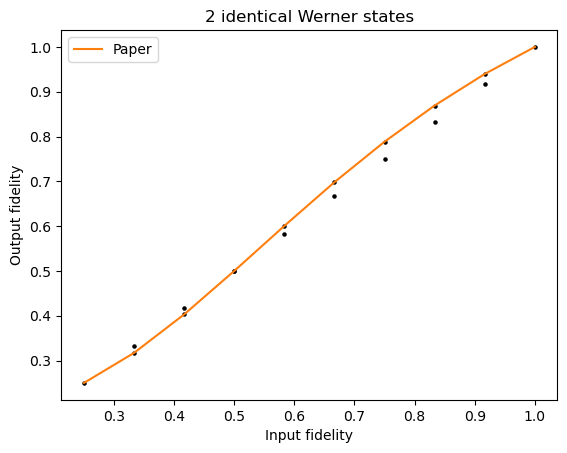

In [14]:
# Plot

# Fidelities
fig, ax1 = plt.subplots()
F_in_vec = np.linspace(F_min, F_max, numF)
for F_in in F_in_vec:
    plt.scatter([F_in for _ in data[F_in][1]], data[F_in][1],
                s=5, color='k')
if m==2:
    Fout_paper_vec = [((10/9)*F_in**2 - (2/9)*F_in + 1/9)/((8/9)*F_in**2 - (4/9)*F_in + 5/9) for F_in in F_in_vec]
elif m==3:
    Fout_paper_vec = [((28/27)*F_in**3 - (1/9)*F_in + 2/27)/((32/27)*F_in**3 - (4/9)*F_in**2 + 7/27) for F_in in F_in_vec]
elif m==4:
    Fout_paper_vec = [((8/9)*F_in**4 + (8/27)*F_in**3 - (2/9)*F_in**2
                       + 1/27) / ((32/27)*F_in**4 - (4/9)*F_in**2 + (4/27)*F_in + 1/9) for F_in in F_in_vec]
else:
    raise ValueError('Value of m not implemented')
plt.plot(F_in_vec, Fout_paper_vec, color='tab:orange', label='Paper')

plt.ylabel('Output fidelity')


# Probabilities
#ax2 = ax1.twinx()
#color2 = 'tab:orange'
#for F_in in np.linspace(F_min, F_max, numF):
#    ax2.scatter([F_in for _ in data[F_in][0]], data[F_in][0],
#                s=5, color=color2, zorder=-1000)
#ax2.set_ylabel('Output fidelity', color=color2)
#ax2.spines['right'].set_color(color2)
#ax2.tick_params(axis='y', which='both', colors=color2)


plt.title('%d identical Werner states'%m)
plt.xlabel('Input fidelity')
plt.legend()

plt.show()